In [1]:
import os
import sys
import math
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from scipy.special import softmax
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW
from transformers import RobertaTokenizerFast, RobertaModel, RobertaForSequenceClassification, get_cosine_schedule_with_warmup
from tqdm import tqdm
import joblib
import zipfile
import transformers
import sklearn
transformers.logging.set_verbosity_error()

In [2]:
# Logging setup
logger = logging.getLogger()
logger.setLevel(logging.INFO)
for handler in logger.handlers[:]:
    logger.removeHandler(handler)
handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(logging.Formatter('%(message)s'))
logger.addHandler(handler)

In [3]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA device count: {torch.cuda.device_count()}")

Using device: cuda
CUDA device name: Tesla T4
CUDA device count: 1


In [4]:
# Log library versions
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.6.0+cu124
Transformers version: 4.52.4
Scikit-learn version: 1.6.1
Pandas version: 2.2.2
NumPy version: 2.0.2


In [5]:
# Configuration
MODEL_NAME = 'roberta-base'
TEXT_COLUMN = 'processed_text'
LABEL_COLUMN = 'status'
MAX_LENGTH = 512
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5
WARMUP_STEPS = 100
DROPOUT_RATE = 0.1

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=1.25, class_weights=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.class_weights = class_weights

    def forward(self, logits, targets):
        # Compute log probabilities
        log_probs = F.log_softmax(logits, dim=-1)
        probs = torch.exp(log_probs)

        # Get probability and log probability for correct class
        pt = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        log_pt = log_probs.gather(1, targets.unsqueeze(1)).squeeze(1)

        # Compute focal weight
        focal_weight = (1.0 - pt) ** self.gamma

        # Compute focal loss
        loss = -focal_weight * log_pt

        # Apply class weights if provided
        if self.class_weights is not None:
            weight = self.class_weights[targets]
            loss *= weight

        return loss.mean()

In [7]:
# Data preparation functions
def prepare_model_input(texts, labels, tokenizer, max_length):
    # Tokenize texts
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']

    # Handle labels
    if isinstance(labels, pd.Series):
        labels = labels.values

    # Convert string labels to numeric if necessary
    if labels.dtype == 'object' or isinstance(labels[0], str):
        le = LabelEncoder()
        labels = le.fit_transform(labels)

    # Convert to tensor
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return input_ids, attention_mask, labels_tensor

def create_dataloader(input_ids, attention_mask, labels, batch_size, shuffle=True):
    dataset = TensorDataset(input_ids, attention_mask, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [8]:
# Enhanced MultiHeadAttentionPooling with better features
class MultiHeadAttentionPooling(torch.nn.Module):
    def __init__(self, hidden_size=768, num_heads=12, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"

        self.query = torch.nn.Linear(hidden_size, hidden_size)
        self.key = torch.nn.Linear(hidden_size, hidden_size)
        self.value = torch.nn.Linear(hidden_size, hidden_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.out_proj = torch.nn.Linear(hidden_size, hidden_size)
        self.scale = math.sqrt(self.head_dim)

        # Layer normalization for stability
        self.layer_norm = torch.nn.LayerNorm(hidden_size)

        # Multi-pooling strategies
        self.pooling_dense = torch.nn.Linear(hidden_size * 3, hidden_size)

    def forward(self, hidden_states, attention_mask=None):
        batch_size, seq_length, hidden_size = hidden_states.size()

        # Apply layer normalization first
        normalized_hidden = self.layer_norm(hidden_states)

        q = self.query(normalized_hidden).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.key(normalized_hidden).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(normalized_hidden).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale

        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(attention_mask == 0, -1e4)

        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = torch.matmul(attn_weights, v).transpose(1, 2).contiguous()
        context = context.view(batch_size, seq_length, hidden_size)
        output = self.out_proj(context)

        # Multiple pooling strategies
        # 1. CLS token (first token)
        cls_output = output[:, 0, :]

        # 2. Mean pooling with attention mask
        if attention_mask is not None:
            mask_expanded = attention_mask.squeeze(1).squeeze(1).unsqueeze(-1).expand(output.size()).float()
            sum_embeddings = torch.sum(output * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            mean_output = sum_embeddings / sum_mask
        else:
            mean_output = torch.mean(output, dim=1)

        # 3. Max pooling
        max_output, _ = torch.max(output, dim=1)

        # Combine all pooling strategies
        combined_pooling = torch.cat([cls_output, mean_output, max_output], dim=-1)
        final_pooled = self.pooling_dense(combined_pooling)

        return final_pooled, attn_weights

# Enhanced Custom RoBERTa model
class CustomRobertaWithAttentionContrastive(torch.nn.Module):
    def __init__(self, model_name, num_labels, dropout_rate=0.3):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)

        # Enhanced attention pooling with more heads
        self.attention_pooling = MultiHeadAttentionPooling(
            hidden_size=768,
            num_heads=12,
            dropout=dropout_rate
        )

        # Multi-layer classifier with residual connections and attention
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.dropout2 = torch.nn.Dropout(dropout_rate * 0.7)
        self.dropout3 = torch.nn.Dropout(dropout_rate * 0.5)

        # Progressive dimension reduction
        self.dense1 = torch.nn.Linear(768, 512)
        self.dense2 = torch.nn.Linear(512, 256)
        self.dense3 = torch.nn.Linear(256, 128)

        # Batch normalization for training stability
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.bn3 = torch.nn.BatchNorm1d(128)

        # Feature attention mechanism for discriminative learning
        self.feature_attention = torch.nn.MultiheadAttention(
            embed_dim=256,
            num_heads=8,
            dropout=dropout_rate,
            batch_first=True
        )

        # Residual connections
        self.residual_proj1 = torch.nn.Linear(768, 512)
        self.residual_proj2 = torch.nn.Linear(512, 256)

        # Final classifier
        self.classifier = torch.nn.Linear(128, num_labels)

        # Feature projection for metric learning
        self.feature_proj = torch.nn.Linear(256, 128)

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        """Initialize weights with Xavier/Glorot initialization"""
        for module in [self.dense1, self.dense2, self.dense3, self.classifier,
                      self.feature_proj, self.residual_proj1, self.residual_proj2]:
            if hasattr(module, 'weight'):
                torch.nn.init.xavier_uniform_(module.weight)
                torch.nn.init.zeros_(module.bias)

    def forward(self, input_ids, attention_mask=None):
        # RoBERTa encoding
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        hidden_states = outputs[0]

        # Enhanced attention pooling
        pooled, attention_weights = self.attention_pooling(hidden_states, attention_mask)

        # First layer with residual connection
        x = self.dropout1(pooled)
        dense1_out = F.gelu(self.bn1(self.dense1(x)))
        residual1 = F.gelu(self.residual_proj1(pooled))
        x = dense1_out + residual1

        # Second layer with residual connection and feature attention
        x = self.dropout2(x)
        dense2_out = F.gelu(self.bn2(self.dense2(x)))
        residual2 = F.gelu(self.residual_proj2(x))
        features_pre_attention = dense2_out + residual2

        # Self-attention on features for better discrimination between similar classes
        features_unsqueezed = features_pre_attention.unsqueeze(1)
        attended_features, feature_attn_weights = self.feature_attention(
            features_unsqueezed, features_unsqueezed, features_unsqueezed
        )
        attended_features = attended_features.squeeze(1)

        # Combine original and attended features
        enhanced_features = features_pre_attention + attended_features

        # Feature projection for contrastive learning
        projected_features = F.normalize(self.feature_proj(enhanced_features), p=2, dim=1)

        # Final classification layer
        x = self.dropout3(enhanced_features)
        final_features = F.gelu(self.bn3(self.dense3(x)))
        logits = self.classifier(final_features)

        return logits, projected_features

In [17]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs, device,
                patience=2, dropout_rate=DROPOUT_RATE, warmup_steps=WARMUP_STEPS, label_encoder=None):
    torch.cuda.empty_cache()
    # Log training configuration
    logger.info("Training Configuration:")
    logger.info(f"  Model: {MODEL_NAME}")
    logger.info(f"  Max Length: {MAX_LENGTH}")
    logger.info(f"  Batch Size: {BATCH_SIZE}")
    logger.info(f"  Epochs: {EPOCHS}")
    logger.info(f"  Learning Rate: {LEARNING_RATE}")
    logger.info(f"  Dropout Rate: {dropout_rate}")
    logger.info(f"  Warmup Steps: {warmup_steps}")
    logger.info(f"  Train Samples: {len(train_loader.dataset)}")
    logger.info(f"  Validation Samples: {len(val_loader.dataset)}")

    # Compute class weights
    class_weights = torch.tensor(
        compute_class_weight('balanced',
                             classes=np.unique(train_loader.dataset.tensors[2].numpy()),
                             y=train_loader.dataset.tensors[2].numpy()),
        dtype=torch.float
    ).to(device)

    # AMP scaler
    scaler = torch.amp.GradScaler(device='cuda')
    criterion = FocalLoss(gamma=1.25, class_weights=class_weights)

    best_val_f1 = 0.0
    epochs_no_improve = 0
    model_save_path = "best_roberta_model_f1.pt"

    # Initialize metrics
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
        'best_epoch': None,
        'best_val_f1': 0.0
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []
        total_train_samples = 0

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            optimizer.zero_grad(set_to_none=True)
            batch_size = input_ids.size(0)
            total_train_samples += batch_size

            with torch.amp.autocast(device_type='cuda'):
                logits, pooled = model(input_ids, attention_mask=attention_mask)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_loss += loss.item() * batch_size
            train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= total_train_samples
        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        total_val_samples = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                batch_size = input_ids.size(0)
                total_val_samples += batch_size

                with torch.amp.autocast(device_type='cuda'):
                    logits, pooled = model(input_ids, attention_mask=attention_mask)
                    loss = criterion(logits, labels)

                val_loss += loss.item() * batch_size
                val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= total_val_samples
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        torch.cuda.empty_cache()
        # Log
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss={train_loss:.4f} | Train Acc={train_acc:.4f} | F1={train_f1:.4f}")
        print(f"Val   Loss={val_loss:.4f} | Val   Acc={val_acc:.4f} | F1={val_f1:.4f}")

        # Save metrics
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['train_f1'].append(train_f1)
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)
        metrics['val_f1'].append(val_f1)

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            metrics['best_epoch'] = epoch + 1
            metrics['best_val_f1'] = val_f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model at epoch {epoch+1}")
        else:
            epochs_no_improve += 1
            print(f" No improvement ({epochs_no_improve}/{patience})")
            if epochs_no_improve >= patience:
                print(" Early stopping.")
                break

    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"\nLoaded best model with F1={best_val_f1:.4f}")

    # Summary
    print("\nTraining Summary:")
    print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Train F1':<12} {'Val Loss':<12} {'Val Acc':<12} {'Val F1':<12}")
    print("-" * 80)
    for e in range(len(metrics['train_loss'])):
        print(f"{e+1:<8} {metrics['train_loss'][e]:<12.4f} {metrics['train_acc'][e]:<12.4f} {metrics['train_f1'][e]:<12.4f} {metrics['val_loss'][e]:<12.4f} {metrics['val_acc'][e]:<12.4f} {metrics['val_f1'][e]:<12.4f}")
    print("-" * 80)
    print(f"Best Epoch: {metrics['best_epoch']}, Best Validation F1: {metrics['best_val_f1']:.4f}")

    # Plot
    output_dir = "sentiment_model_components"
    os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(metrics['train_loss']) + 1), metrics['train_loss'], label='Train Loss')
    plt.plot(range(1, len(metrics['val_loss']) + 1), metrics['val_loss'], label='Val Loss')
    plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(metrics['train_acc']) + 1), metrics['train_acc'], label='Train Acc')
    plt.plot(range(1, len(metrics['val_acc']) + 1), metrics['val_acc'], label='Val Acc')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, len(metrics['train_f1']) + 1), metrics['train_f1'], label='Train F1')
    plt.plot(range(1, len(metrics['val_f1']) + 1), metrics['val_f1'], label='Val F1')
    plt.title('F1-Score'); plt.xlabel('Epoch'); plt.ylabel('F1'); plt.legend()

    plt.tight_layout()
    metrics_plot_path = os.path.join(output_dir, 'training_metrics_with_f1.png')
    plt.savefig(metrics_plot_path)
    plt.close()
    print(f"Training plot saved at: {metrics_plot_path}")
    return model

In [10]:
def perform_error_analysis(model, test_dataloader, label_encoder, device, test_original_texts, top_k=50):
    """
    Perform detailed error analysis on test set
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_logits = []
    texts = []

    print("Performing error analysis...")

    with torch.no_grad():
        text_idx = 0  # Track current text index
        for batch in tqdm(test_dataloader, desc="Error Analysis"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            batch_size = input_ids.size(0)

            # Get model outputs
            logits, _ = model(input_ids, attention_mask=attention_mask)

            # Store results
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.extend(logits.cpu().numpy())

            batch_texts = test_original_texts[text_idx:text_idx + batch_size]
            texts.extend(batch_texts)
            text_idx += batch_size  # Update text index

            # Clean up memory
            del input_ids, attention_mask, labels, logits

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_logits = np.array(all_logits)

    # Get class names
    class_names = label_encoder.classes_

    # 1. Overall accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Test Accuracy: {accuracy:.4f}")

    # 2. Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # 3. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # 4. Find worst predictions (highest confidence but wrong)
    probabilities = softmax(all_logits, axis=1)
    max_probs = np.max(probabilities, axis=1)
    predicted_classes = np.argmax(probabilities, axis=1)

    # Find incorrect predictions
    incorrect_mask = (predicted_classes != all_labels)
    incorrect_indices = np.where(incorrect_mask)[0]

    if len(incorrect_indices) > 0:
        # Sort by confidence (descending) for wrong predictions
        incorrect_confidences = max_probs[incorrect_indices]
        sorted_indices = incorrect_indices[np.argsort(-incorrect_confidences)]

        print(f"\nTop {min(top_k, len(sorted_indices))} Most Confident Wrong Predictions:")
        print("="*100)

        for i, idx in enumerate(sorted_indices[:top_k]):
            true_label = class_names[all_labels[idx]]
            pred_label = class_names[predicted_classes[idx]]
            confidence = max_probs[idx]
            text = texts[idx][:200] + "..." if len(texts[idx]) > 200 else texts[idx]

            print(f"\n{i+1}. Confidence: {confidence:.4f}")
            print(f"   True: {true_label} | Predicted: {pred_label}")
            print(f"   Text: {text}")
            print("-" * 80)

    # 5. Class-wise performance analysis
    print(f"\nClass-wise Error Analysis:")
    print("="*50)

    for i, class_name in enumerate(class_names):
        class_mask = (all_labels == i)
        class_correct = (all_preds[class_mask] == i).sum()
        class_total = class_mask.sum()
        class_accuracy = class_correct / class_total if class_total > 0 else 0

        print(f"{class_name}: {class_accuracy:.4f} ({class_correct}/{class_total})")

        # Find most confused class for this true class
        if class_total > 0:
            class_preds = all_preds[class_mask]
            wrong_preds = class_preds[class_preds != i]
            if len(wrong_preds) > 0:
                most_confused = np.bincount(wrong_preds).argmax()
                confusion_count = (class_preds == most_confused).sum()
                print(f"   Most confused with: {class_names[most_confused]} ({confusion_count} times)")

    # 6. Confidence distribution analysis
    plt.figure(figsize=(12, 4))

    # Correct vs Incorrect confidence distribution
    plt.subplot(1, 2, 1)
    correct_conf = max_probs[~incorrect_mask]
    incorrect_conf = max_probs[incorrect_mask]

    plt.hist(correct_conf, bins=20, alpha=0.7, label='Correct', color='green')
    plt.hist(incorrect_conf, bins=20, alpha=0.7, label='Incorrect', color='red')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title('Confidence Distribution')
    plt.legend()

    # Per-class confidence
    plt.subplot(1, 2, 2)
    class_confidences = []
    for i in range(len(class_names)):
        class_mask = (all_labels == i)
        if class_mask.sum() > 0:
            class_confidences.append(max_probs[class_mask])
        else:
            class_confidences.append([])

    plt.boxplot(class_confidences, labels=class_names)
    plt.ylabel('Confidence')
    plt.title('Confidence by True Class')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': probabilities,
    }

In [12]:
train_df = pd.read_csv('/content/train.csv')
val_df = pd.read_csv('/content/val.csv')
test_df = pd.read_csv('/content/test.csv')

In [13]:
# Encode labels
label_encoder = LabelEncoder()
train_df['labels'] = label_encoder.fit_transform(train_df[LABEL_COLUMN])
val_df['labels'] = label_encoder.transform(val_df[LABEL_COLUMN])
test_df['labels'] = label_encoder.transform(test_df[LABEL_COLUMN])

NUM_LABELS = len(label_encoder.classes_)
class_names = label_encoder.classes_

logger.info(f"Number of unique labels: {NUM_LABELS}")
logger.info(f"Class names: {class_names}")

label_counts = train_df['labels'].value_counts().sort_index()
for i, count in enumerate(label_counts):
    label_name = class_names[i]
    logger.info(f"Label '{label_name}' (encoded as {i}): {count} samples")

Number of unique labels: 7
Class names: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
Label 'Anxiety' (encoded as 0): 2654 samples
Label 'Bipolar' (encoded as 1): 1944 samples
Label 'Depression' (encoded as 2): 15494 samples
Label 'Normal' (encoded as 3): 9586 samples
Label 'Personality disorder' (encoded as 4): 753 samples
Label 'Stress' (encoded as 5): 1804 samples
Label 'Suicidal' (encoded as 6): 12252 samples


In [14]:
# Data augmentation using oversampling
def oversample_data(train_df, class_names, num_labels):
    if train_df.empty or 'processed_text' not in train_df.columns or 'labels' not in train_df.columns:
        print("Error: Invalid input DataFrame. Ensure it contains 'processed_text' and 'labels' columns.")
        return train_df.copy()

    augmented_data = []
    label_counts = train_df['labels'].value_counts()

    if label_counts.empty:
        print("Error: No valid labels found in the dataset.")
        return train_df.copy()

    majority_class_count = label_counts.max()
    imbalance_ratio = majority_class_count / label_counts.min() if label_counts.min() > 0 else float('inf')

    if imbalance_ratio > 1.5:
        for label_id in range(num_labels):
            class_df = train_df[train_df['labels'] == label_id]
            if class_df.empty:
                print(f"Warning: No samples found for class {label_id} ({class_names[label_id]}). Skipping oversampling.")
                continue

            num_to_augment = majority_class_count - len(class_df)

            if num_to_augment <= 0:
                continue

            # Dynamic oversampling multiplier based on class size
            class_size_ratio = len(class_df) / majority_class_count
            if class_size_ratio < 0.1:
                num_oversample_multiplier = 3
            elif class_size_ratio < 0.2:
                num_oversample_multiplier = 2
            elif class_size_ratio < 0.4:
                num_oversample_multiplier = 1
            else:
                num_oversample_multiplier = 0

            target_count = min(majority_class_count, int(len(class_df) * (1 + num_oversample_multiplier)))
            num_samples_to_create = target_count - len(class_df)

            if num_samples_to_create <= 0:
                continue

            print(f"Class {label_id} ({class_names[label_id]}): oversampling {num_samples_to_create} samples from {len(class_df)} original samples.")

            # Sample with replacement to create new samples
            indices_to_sample = np.random.choice(class_df.index, size=num_samples_to_create, replace=True)
            sampled_data = class_df.loc[indices_to_sample, ['processed_text', 'labels']].to_dict('records')
            augmented_data.extend(sampled_data)

    else:
        print("Class distribution is relatively balanced. Skipping oversampling.")

    # Combine original and oversampled data
    combined_train_df = train_df.copy()
    if augmented_data:
        augmented_df = pd.DataFrame(augmented_data)
        combined_train_df = pd.concat([train_df, augmented_df], ignore_index=True)
        combined_train_df = combined_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Print statistics
    print(f"\nOriginal training samples: {len(train_df)}")
    print(f"Oversampled samples added: {len(augmented_data)}")
    print(f"Total training samples after oversampling: {len(combined_train_df)}")
    print("\nTraining set label distribution after oversampling:")
    print(combined_train_df['labels'].value_counts(normalize=True))

    return combined_train_df

train_df = oversample_data(train_df, class_names=class_names, num_labels=NUM_LABELS)

Class 0 (Anxiety): oversampling 5308 samples from 2654 original samples.
Class 1 (Bipolar): oversampling 3888 samples from 1944 original samples.
Class 4 (Personality disorder): oversampling 2259 samples from 753 original samples.
Class 5 (Stress): oversampling 3608 samples from 1804 original samples.

Original training samples: 44487
Oversampled samples added: 15063
Total training samples after oversampling: 59550

Training set label distribution after oversampling:
labels
2    0.260185
6    0.205743
3    0.160974
0    0.133703
1    0.097935
5    0.090882
4    0.050579
Name: proportion, dtype: float64


In [15]:
# Prepare data
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

train_input_ids, train_attention_mask, train_labels = prepare_model_input(
    train_df[TEXT_COLUMN].tolist(), train_df['labels'], tokenizer, MAX_LENGTH
)
val_input_ids, val_attention_mask, val_labels = prepare_model_input(
    val_df[TEXT_COLUMN].tolist(), val_df['labels'], tokenizer, MAX_LENGTH
)
test_input_ids, test_attention_mask, test_labels = prepare_model_input(
    test_df[TEXT_COLUMN].tolist(), test_df['labels'], tokenizer, MAX_LENGTH
)
train_dataloader = create_dataloader(train_input_ids, train_attention_mask, train_labels, BATCH_SIZE)
val_dataloader = create_dataloader(val_input_ids, val_attention_mask, val_labels, BATCH_SIZE, shuffle=False)
test_dataloader = create_dataloader(test_input_ids, test_attention_mask, test_labels, BATCH_SIZE, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
model = CustomRobertaWithAttentionContrastive(
    model_name=MODEL_NAME,
    num_labels=NUM_LABELS,
    dropout_rate=DROPOUT_RATE
).to(device)

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01,
    eps=1e-8
)

# Scheduler
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=len(train_dataloader) * EPOCHS
)

# Training
model = train_model(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    scheduler,
    EPOCHS,
    device,
    patience=2,
    dropout_rate=DROPOUT_RATE,
    warmup_steps=WARMUP_STEPS
)

Training Configuration:
  Model: roberta-base
  Max Length: 512
  Batch Size: 16
  Epochs: 5
  Learning Rate: 2e-05
  Dropout Rate: 0.1
  Warmup Steps: 100
  Train Samples: 59550
  Validation Samples: 9533


Validation Epoch 1: 100%|██████████| 596/596 [01:11<00:00,  8.38it/s]



Epoch 1/5
Train Loss=0.4358 | Train Acc=0.7480 | F1=0.7467
Val   Loss=0.2482 | Val   Acc=0.8059 | F1=0.8072
Saved best model at epoch 1


Validation Epoch 2: 100%|██████████| 596/596 [01:10<00:00,  8.40it/s]



Epoch 2/5
Train Loss=0.1575 | Train Acc=0.8621 | F1=0.8616
Val   Loss=0.2755 | Val   Acc=0.8261 | F1=0.8272
Saved best model at epoch 2


Validation Epoch 3: 100%|██████████| 596/596 [01:11<00:00,  8.39it/s]



Epoch 3/5
Train Loss=0.1069 | Train Acc=0.8904 | F1=0.8902
Val   Loss=0.2577 | Val   Acc=0.8296 | F1=0.8294
Saved best model at epoch 3


Validation Epoch 4: 100%|██████████| 596/596 [01:11<00:00,  8.39it/s]



Epoch 4/5
Train Loss=0.0794 | Train Acc=0.9106 | F1=0.9105
Val   Loss=0.2901 | Val   Acc=0.8336 | F1=0.8339
Saved best model at epoch 4


Validation Epoch 5: 100%|██████████| 596/596 [01:11<00:00,  8.35it/s]



Epoch 5/5
Train Loss=0.0653 | Train Acc=0.9249 | F1=0.9249
Val   Loss=0.3066 | Val   Acc=0.8326 | F1=0.8331
 No improvement (1/2)

Loaded best model with F1=0.8339

Training Summary:
Epoch    Train Loss   Train Acc    Train F1     Val Loss     Val Acc      Val F1      
--------------------------------------------------------------------------------
1        0.4358       0.7480       0.7467       0.2482       0.8059       0.8072      
2        0.1575       0.8621       0.8616       0.2755       0.8261       0.8272      
3        0.1069       0.8904       0.8902       0.2577       0.8296       0.8294      
4        0.0794       0.9106       0.9105       0.2901       0.8336       0.8339      
5        0.0653       0.9249       0.9249       0.3066       0.8326       0.8331      
--------------------------------------------------------------------------------
Best Epoch: 4, Best Validation F1: 0.8339
Training plot saved at: sentiment_model_components/training_metrics_with_f1.png


Performing error analysis...


Error Analysis: 100%|██████████| 596/596 [04:33<00:00,  2.18it/s]



Overall Test Accuracy: 0.8311

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.91      0.91      0.91       569
             Bipolar       0.84      0.83      0.84       416
          Depression       0.82      0.74      0.78      3320
              Normal       0.97      0.95      0.96      2055
Personality disorder       0.81      0.75      0.78       161
              Stress       0.80      0.84      0.82       387
            Suicidal       0.74      0.83      0.78      2625

            accuracy                           0.83      9533
           macro avg       0.84      0.84      0.84      9533
        weighted avg       0.83      0.83      0.83      9533



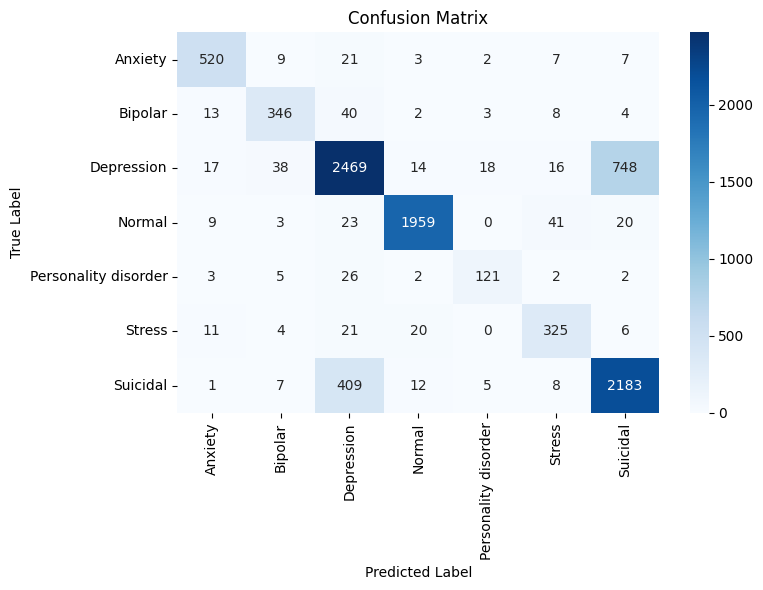


Top 50 Most Confident Wrong Predictions:

1. Confidence: 0.9979
   True: Bipolar | Predicted: Personality disorder
   Text: I hurt someone today It's said that those you push away the hardest, and still somehow fight to remain should be cherished, and I do cherish you. Even though sometimes my actions speak otherwise, deep...
--------------------------------------------------------------------------------

2. Confidence: 0.9963
   True: Anxiety | Predicted: Bipolar
   Text: I’ve been trying to get help for months it’s so frustrating Our healthcare system is so over burdened. The psychiatrist in town has an almost 9 month wait list (but I finally got in). The community/pa...
--------------------------------------------------------------------------------

3. Confidence: 0.9948
   True: Depression | Predicted: Personality disorder
   Text: I’m getting more and more jealous of rich people and feel terrible about it. How do other people cope? I’ve been poor most of my life and even though

/tmp/ipython-input-10-2623241435.py:135: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(class_confidences, labels=class_names)


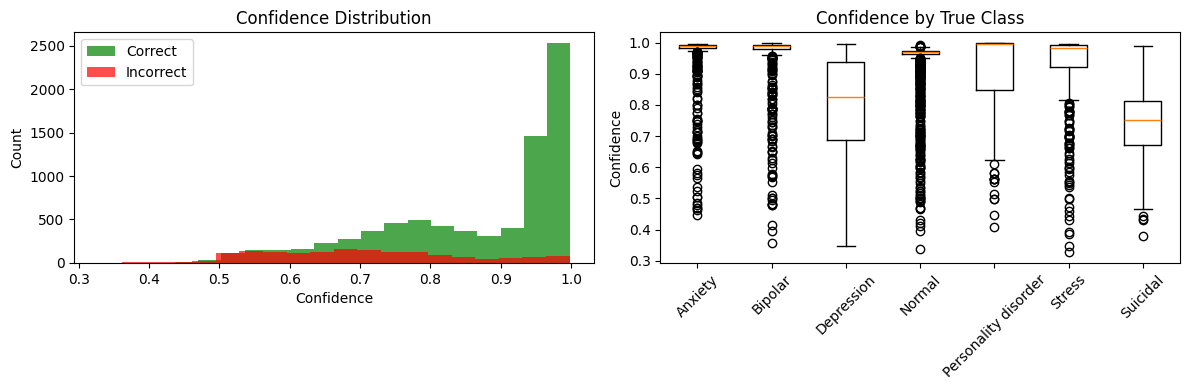

{'accuracy': 0.831112975978181,
 'predictions': array([6, 2, 6, ..., 4, 5, 2]),
 'labels': array([3, 2, 6, ..., 4, 5, 2]),
 'probabilities': array([[3.6468171e-03, 1.4286153e-03, 3.8207632e-03, ..., 5.2675167e-03,
         4.5378013e-03, 9.5573080e-01],
        [1.3945686e-03, 2.4180042e-03, 8.3474708e-01, ..., 1.5387186e-03,
         1.4084812e-03, 1.5701236e-01],
        [2.1804453e-04, 8.6812477e-04, 2.6534742e-01, ..., 8.1248191e-04,
         7.0952286e-04, 7.3154354e-01],
        ...,
        [1.2452878e-03, 6.2277180e-04, 2.4983028e-02, ..., 9.7197425e-01,
         6.6271279e-04, 2.0894033e-04],
        [1.4094725e-03, 1.1687619e-03, 2.5403939e-05, ..., 2.2460427e-03,
         8.5856795e-01, 2.1339521e-04],
        [6.9056195e-04, 2.3127939e-03, 8.1280726e-01, ..., 2.4939401e-03,
         1.0244176e-03, 1.7927378e-01]], dtype=float32)}

In [19]:
# Perform error analysis
perform_error_analysis(model, test_dataloader, label_encoder, device, test_df[TEXT_COLUMN].tolist())

In [20]:
# Save model, tokenizer, and label encoder
model_save_path = "last_roberta_model.pt"
label_encoder_save_path = "label_encoder.joblib"
tokenizer_save_path = "roberta_tokenizer"
output_dir = "sentiment_model_components"
os.makedirs(output_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(output_dir, model_save_path))
print(f"Saved model state_dict at: {os.path.join(output_dir, model_save_path)}")
joblib.dump(label_encoder, os.path.join(output_dir, label_encoder_save_path))
print(f"Saved LabelEncoder at: {os.path.join(output_dir, label_encoder_save_path)}")
tokenizer.save_pretrained(os.path.join(output_dir, tokenizer_save_path))
print(f"Saved tokenizer at: {os.path.join(output_dir, tokenizer_save_path)}")
zip_file_name = "sentiment_model_components.zip"
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, start=output_dir)
            zf.write(file_path, os.path.join(os.path.basename(output_dir), arcname))
print(f"Compressed all components to: {zip_file_name}")

Saved model state_dict at: sentiment_model_components/last_roberta_model.pt
Saved LabelEncoder at: sentiment_model_components/label_encoder.joblib
Saved tokenizer at: sentiment_model_components/roberta_tokenizer
Compressed all components to: sentiment_model_components.zip


In [21]:
# Model loading
def load_model_and_tokenizer(model_path, tokenizer_path, num_labels, device):
    model = CustomRobertaWithAttentionContrastive(MODEL_NAME, num_labels).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_path)
    return model, tokenizer

In [22]:
# Test model loading
print("\nTesting model loading:")
loaded_model, loaded_tokenizer = load_model_and_tokenizer(
    os.path.join(output_dir, model_save_path), os.path.join(output_dir, tokenizer_save_path), NUM_LABELS, device
)
print("Model and tokenizer loaded successfully.")


Testing model loading:
Model and tokenizer loaded successfully.
